In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from scipy.integrate import quad
from scipy.optimize import minimize
from statsmodels.distributions.empirical_distribution import ECDF

In [3]:
# Note: Tools in this file only supports np.ndarray but not pd.Series nor pd.DataFrame
import numpy as np
from scipy.stats import norm, chi2

from scipy.linalg import toeplitz
# from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.adfvalues import mackinnonp


class OLS:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.params = np.linalg.inv(X.T @ X) @ X.T @ y
        self.y_hat = X @ self.params
        self.e = y - self.y_hat
        self.n, self.k = X.shape
        self.k -= 1
        self.R2 = None
        self.V_hat = None
        self.params_std = None
        self.V_white_hat = None
        self.params_white_std = None
        self.logL = None
    
    def get_R2(self):
        SSR = (self.e ** 2).sum()
        SST = ((self.y - self.y.mean()) ** 2).sum()
        self.R2 = 1 - SSR / SST
        return self.R2
    
    def get_adjusted_R2(self):
        if self.R2 is None:
            self.get_R2()
        adjusted_R2 = 1 - (1 - self.R2) * (self.n - 1) / (self.n - self.k - 1)
        return adjusted_R2
    
    def get_V_hat(self):
        sigma2_hat = 1 / (self.n - self.k) * (self.e**2).sum()
        self.V_hat = np.linalg.inv(self.X.T @ self.X) * sigma2_hat
        return self.V_hat
    
    def get_params_std(self):
        if self.V_hat is None:
            self.get_V_hat()
        self.params_std = np.sqrt(self.V_hat.diagonal())
        return self.params_std
    
    def t_test(self):
        if self.params_std is None:
            self.get_params_std()
        t_values = self.params / self.params_std
        p_values = np.where(t_values > 0,
                            (1 - norm.cdf(t_values)) * 2, 
                            norm.cdf(t_values) * 2
                           )
        return t_values, p_values
    
    def white_test(self):
        u2 = self.e ** 2
        X_noconst = self.X[:,1:]
        X_white = self.X.copy()
        for j in range(X_noconst.shape[1]):
            X_white = np.hstack([X_white, X_noconst[:,[j]] * X_noconst[:,j:]])
        ols_white = OLS(X_white, u2)
        R2_white = ols_white.get_R2()
        TR2 = ols_white.n * R2_white
        p_value_white = 1 - chi2.cdf(TR2, df=ols_white.k)
        return TR2, p_value_white
    
    def get_V_white_hat(self):
        D = np.diag(self.e ** 2)
        self.V_white_hat = np.linalg.inv(self.X.T @ self.X) @ (self.X.T @ D @ self.X) @ np.linalg.inv(self.X.T @ self.X)
        return self.V_white_hat # white variance-covariance matrix
    
    def get_params_white_std(self):
        if self.V_white_hat is None:
            self.get_V_white_hat()
        self.params_white_std = np.sqrt(np.diagonal(self.V_white_hat))
        return self.params_white_std
    
    def t_test_white(self):
        if self.params_white_std is None:
            self.get_params_white_std()
        t_values_white = self.params / self.params_white_std
        p_values_white = np.where(t_values_white > 0,
                                  2 * (1 - norm.cdf(t_values_white)),
                                  2 * norm.cdf(t_values_white)
                                 )
        return t_values_white, p_values_white
    
    def get_logL(self):
        sigma2_hat = 1 / (self.n - self.k - 1) * (self.e**2).sum()
        self.logL = - self.n / 2 * np.log(2 * np.pi) - \
                    self.n / 2 * np.log(sigma2_hat) - \
                    (self.e ** 2).sum() / (2 * sigma2_hat)
        return self.logL
    
    def get_AIC(self):
        if self.logL is None:
            self.get_logL()
        AIC = - 2 * self.logL + 2 * self.k
        return AIC
        
    def get_BIC(self):
        if self.logL is None:
            self.get_logL()
        BIC = - 2 * self.logL + self.k * np.log(self.n)
        return BIC
        
    def get_HQ(self):
        if self.logL is None:
            self.get_logL()
        HQ = - 2 * self.logL + 2 * self.k * np.log(np.log(self.n))
        return HQ
    
    def DW_test(self):
        ut = self.e[1:]
        ut_1 = self.e[:-1]
        DW = ((ut - ut_1) ** 2).sum() / (ut ** 2).sum()
        return DW
    
    def BG_test(self, lag=3):
        X_BG = np.full((len(self.e),lag), np.nan)
        for j in range(1, lag + 1):
            X_BG[j:,j-1] = self.e[:-j]
        u = self.e[lag:]
        X_BG = X_BG[lag:,:]
        ols_BG = OLS(X_BG, u)
        R2_BG = ols_BG.get_R2()
        T_r_R2 = (self.n - lag) * R2_BG # ~ chi2(r)
        p_value_BG = 1 - chi2.cdf(T_r_R2, df=lag)
        return T_r_R2, p_value_BG
    
    def qqplot_e(self):
        cdfs = (np.arange(len(self.e)) + 0.5) / len(self.e) # 0 ~ 1 ex: if there ara 100 hunred points, it will be like 0.01, 0.02, ...
        theoretical_distribution = norm.ppf(cdfs) # from the probability to the value in the normal distribution ex: 0.975->1.96
        fig = plt.figure()
        plt.scatter(theoretical_distribution, np.sort(self.e), s=15)
        benchmark_line = [min(self.e.min(), theoretical_distribution.min()),
                          max(self.e.max(), theoretical_distribution.max())]
        plt.plot(benchmark_line, benchmark_line, c="r")
        plt.xlabel("Quantile of normal distribution")
        plt.ylabel("Quantile of residuals")
        plt.show()
    
    def get_cond(self):
        return np.linalg.cond(self.X.T @ self.X)
    
    def RESET_test(self):
        X1 = np.hstack([self.X, (self.y_hat ** 2).reshape((-1,1))])
        ols_RESET = OLS(X1, y)
        t_values_RESET, p_values_RESET = ols_RESET.t_test()
        t_value_yhat2 = t_values_RESET[-1]
        p_value_yhat2 = p_values_RESET[-1]
        return t_value_yhat2, p_value_yhat2
    
    def stability_analysis(self, window, t=None):
        betas = []
        upper_bounds = []
        lower_bounds = []
        for i in range(self.X.shape[0] - window):
            X_i = self.X[i:i+window,:]
            y_i = self.y[i:i+window]
            ols_stab = OLS(X_i, y_i)
            beta_i = ols_stab.params[1]
            betas.append(beta_i)
            beta_i_std = ols_stab.get_params_std()[1]
            lower_bounds.append(beta_i + norm.ppf(0.025) * beta_i_std)
            upper_bounds.append(beta_i + norm.ppf(0.975) * beta_i_std)
        
        if t is None:
            t = np.arange(len(betas))
        fig = plt.figure()
        plt.plot(t, betas)
        plt.fill_between(t, lower_bounds, upper_bounds, alpha=0.3)
        plt.xlabel("t")
        plt.ylabel("beta estimate")
        plt.show()
        
    def predict(self, X_new):
        return X_new @ self.params
    

class TSA:
    def __init__(self, x):
        self.x = x
    
    # ACF & PACF
    def _lag_mat(self, nlags, x=None):
        if x is None:
            x = self.x
        x_lags = np.full((len(x), nlags + 1), np.nan)
        # include 0 lag
        for lag in range(nlags + 1):
            x_lags[lag:, lag] = np.roll(x, shift=lag)[lag:]
        return x_lags
    
    def cal_acf_lag(self, lag):
        if lag == 0:
            return 1.
        return np.corrcoef(self.x[lag:], self.x[:-lag])[1,0]
    
    def cal_acf(self, nlags):
        lag_mat = self._lag_mat(nlags)
        acf_l = [1] + [np.corrcoef(lag_mat[lag:,0], lag_mat[lag:,lag])[1,0] for lag in range(1, nlags + 1)]
        return np.array(acf_l)
    
    def cal_pacf_lag(self, lag):
        # should be the same with sm.tsa.stattools.acf
        # Method1:
        # Reference: https://zhuanlan.zhihu.com/p/430514606
        x = self.x - self.x.mean()
        x_prime = x.copy()
        x = x.reshape((-1,1))
        n = len(x)
        
        gamma_l = []
        gamma_l.append((x_prime @ x) / n) # gamma(0)
        for i in range(1, lag + 1):
            gamma_l.append((x_prime[i:] @ x[:-i]) / (n - i)) # gamma(lag)
        
        R_mat = toeplitz(gamma_l[:-1])
        # solve R_mat @ phi_hat = gamma_arr
        phi_hat = np.linalg.inv(R_mat) @ np.array(gamma_l[1:]).reshape((-1,1))
        return phi_hat[-1].item()
        # Method2:
        # run the following ols regression
        # x_t = beta_0 + beta_1*x_t-1 + beta_2*x_t-2 + ... + beta_lag*x_t-lag + e_t
        # beta_lag is pacf for lag n
    
    def cal_pacf(self, nlags):
        # should be the same with sm.tsa.stattools.pacf
        pacf_l = [1]
        for lag in range(1, nlags + 1):
            pacf_l.append(self.cal_pacf_lag(lag))
        return np.array(pacf_l)
        
    def plot_acf(self, nlags, acf_arr=None, ax=None):
        # should be the same with statsmodels.graphics.tsaplots.plot_acf
        if acf_arr is None:
            acf_arr = self.cal_acf(nlags)
        # For details: cf. slide 23 of Lecture 1 and part on bartlett_confin on
        # https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html
        n = len(self.x)
        se_approx = np.sqrt((np.insert(1 + 2 * np.cumsum(acf_arr ** 2), 0, 1, axis=0)[:-1]) / n)
        if ax is None:
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
        ax.plot(acf_arr, c='xkcd:true blue', marker='o', markerfacecolor='xkcd:azure')
        ax.fill_between(x=range(nlags+1), y1=-1.96*se_approx, y2=1.96*se_approx, facecolor='blue', alpha=0.1)
        ax.set_xlabel("lag")
        ax.axhline(y=0, linewidth=0.4)
        ax.set_title("ACF Figure")
        
    def plot_pacf(self, nlags, pacf_arr=None, ax=None):
        # should be the same with statsmodels.graphics.tsaplots.plot_pacf
        if pacf_arr is None:
            pacf_arr = self.cal_pacf(nlags)
        n = len(self.x)
        se = np.ones(nlags + 1) * np.sqrt(1 / n)
        if ax is None:
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
        ax.plot(pacf_arr, c='xkcd:true blue', marker='o', markerfacecolor='xkcd:azure')
        ax.fill_between(x=range(nlags+1), y1=-1.96*se, y2=1.96*se, facecolor='blue', alpha=0.1)
        ax.set_xlabel("lag")
        ax.axhline(y=0, linewidth=0.4)
        ax.set_title("PACF Figure")

    # Stationarity test: ADF test
    def _get_ADF_X_y(self, lag, terms="n"):
        delta_x = self.x[1:] - self.x[:-1]
        delta_lag_mat = self._lag_mat(lag, delta_x)
        y = delta_lag_mat[lag:, 0] # trancate
        X_delta_lag = delta_lag_mat[lag:, 1:] # trancate
        xt_1 = self.x[:-1]
        Xt_1 = xt_1[lag:].reshape((-1,1)) # trancate
        if terms == "ctt":
            n_ = len(y)
            constant_term = np.ones((n_,1))
            trend_term = np.arange(lag + 1, n_ + lag + 1).reshape((-1,1))
            trend_square_term = trend_term ** 2
            X = np.hstack([Xt_1, X_delta_lag, constant_term, trend_term, trend_square_term])
        elif terms == "ct":
            n_ = len(y)
            constant_term = np.ones((n_,1))
            trend_term = np.arange(lag + 1, n_ + lag + 1).reshape((-1,1))
            X = np.hstack([Xt_1, X_delta_lag, constant_term, trend_term])
        elif terms == "c":
            n_ = len(y)
            constant_term = np.ones((n_,1))
            X = np.hstack([Xt_1, X_delta_lag, constant_term])
        elif terms == "n":
            X = np.hstack([Xt_1, X_delta_lag])
        return X, y

    def _are_terms_significant(self, n_terms, ols, maxlag, criterion):
        assert n_terms >= 1, "n_terms should be at no less than 1"
        mapping_dict = {3: "ctt", 2: "ct", 1: "c", 0: "n"}
        terms = mapping_dict[n_terms]
        
        terms_ADF_stats = ols.params[-n_terms:] / ols.get_params_std()[-n_terms:]
        ADF_p_values = np.array([mackinnonp(adf_stat, terms, N=1) for adf_stat in terms_ADF_stats])
        if (ADF_p_values < 0.05).all():
            # print("Reject null hypothesis. No evidence shows that it has a unit root.")
            # print("The time series is STATIONARY.")
            return True
        else:
            # print("Cannot reject the null hypothesis that it has a unit root")
            # print("The time series is UNSTATIONARY.")
            return False
        
        # OLD VERSION CODE (CAN BE REMOVED)
        # # get ADF critical values
        # result = adfuller(self.x, maxlag, terms, criterion)
        # critical_values = result[4]
        # if (critical_values["1%"] > critical_values["5%"] and (terms_ADF_stats > critical_values["5%"]).all()) \
        # or (critical_values["1%"] < critical_values["5%"] and (terms_ADF_stats < critical_values["5%"]).all()):
        #     # print("Reject null hypothesis. No evidence shows that it has a unit root.")
        #     # print("The time series is STATIONARY.")
        #     return True
        # else:
        #     # print("Cannot reject the null hypothesis that it has a unit root")
        #     # print("The time series is UNSTATIONARY.")
        #     return False
    
    def ADF_regression(self, maxlag=5, terms="n", criterion="AIC"):
        """
        maxlag: max lag attempt
        regression: "n" - no constant nor trend term
                    "c" - only constant term
                    "ct" - constant and trend (i.e. t) term
                    "ctt" - constant, trend and quadratic trend term
        criterion: "AIC", "BIC" - the criterion to choose the best model (best lag)
                   to judge whether the time series is stationary or not
        """
        cri_l = [] # record criterion value for each lag
        for lag in range(1, maxlag + 1):
            X, y = self._get_ADF_X_y(lag, terms)
            ols = OLS(X, y)
            if criterion == "AIC":
                cri = ols.get_AIC()
            elif criterion == "BIC":
                cri = ols.get_BIC()
            cri_l.append(cri)
        best_lag = np.argmin(cri_l) + 1
        # print(f"The best lag for ADF regression is {best_lag}")
        X, y = self._get_ADF_X_y(best_lag, terms)
        ols = OLS(X, y)
        return ols, best_lag
    
    def ADF_test(self, maxlag=5, terms="n", criterion="AIC", ols=None):
        if ols is None:
            ols, best_lag = self.ADF_regression(maxlag, terms, criterion)
        else:
            best_lag = None
        rho_hat = ols.params[0]
        rho_std = ols.get_params_std()[0]
        ADF_stats = rho_hat / rho_std # or t_values, _ = ols.t_test(); ADF_stats = t_values[0]
        ADF_p_value = mackinnonp(ADF_stats, terms, N=1)        
        
        # OLD VERSION CODE (CAN BE REMOVED)
        # result = adfuller(self.x, maxlag, terms, criterion)
        # # adf_test_statistics = result[0] # adf statistics: rho_hat / se(rho_hat)
        # ADF_p_value = result[1] # adf statistics p-value
        # # usedlag = result[2] # the same with `best_lag`
        # # nob = result[3] # number of objects
        # # critical_values = result[4] # dict: critical values for 1%, 5%, and 10%
        
        return ADF_stats, ADF_p_value, best_lag

    def ADF_test_complete(self, maxlag=5, criterion='AIC'):
        """
        maxlag: max lag attempt
        criterion: "AIC", "BIC" - the criterion to choose the best model (best lag)
                   to judge whether the time series is stationary or not
        """
        # first determine the terms to add: "ctt" or "ct" or "c" or "n"
        # then conduct ADF test with proper terms
        mapping_dict = {3: "ctt", 2: "ct", 1: "c", 0: "n"}
        n_terms = 3
        terms = mapping_dict[n_terms]
        ols, best_lag = self.ADF_regression(maxlag, terms, criterion)
        while not self._are_terms_significant(n_terms, ols, maxlag, criterion):
            n_terms -= 1
            terms = mapping_dict[n_terms]
            ols, best_lag = self.ADF_regression(maxlag, terms, criterion)
            if n_terms == 0:
                break
        ADF_stats, ADF_p_value, _ = self.ADF_test(maxlag, terms, criterion, ols)
        return ADF_stats, ADF_p_value, best_lag, terms
    
    def AR(self, p):
        lag_mat = self._lag_mat(p)
        y = lag_mat[p:, 0]
        X = lag_mat[p:, 1:]
        return OLS(X, y)

In [4]:
def get_historical_price_data(ticker,period=1):
    start_date = pd.Timestamp("2000-01-01")
    end_date = pd.Timestamp("today")
    df = yf.download(ticker, start=start_date, end=end_date)[['Adj Close']]
    df['normalized_price'] = (df['Adj Close']-df['Adj Close'].min()) / (df['Adj Close'].max()-df['Adj Close'].min())
    df['total_ret'] = df['Adj Close'].pct_change()
    df['log_ret'] = np.log(df['Adj Close']) - np.log(df['Adj Close'].shift(period))
    return df

In [5]:
def get_uv_from_xy(x,y):
    x_cdf = ECDF(x)
    y_cdf = ECDF(y)
    len_x = len(x)
    len_y = len(y)
    u, v = [len_x/(len_x+1)*x_cdf(a) for a in x], [len_y/(len_y+1)*y_cdf(a) for a in y]
    return u,v


def get_parameter(family, tau):
    """Estimate the theta parameter for the copula based on Kendall tau"""
    if  family == 'clayton':
        return 2 * tau / (1 - tau)

    elif family == 'frank':
        integrand = lambda t: t / (np.exp(t) - 1)  # generate the integrand
        frank_fun = lambda theta: ((tau - 1) / 4.0  - (quad(integrand, sys.float_info.epsilon, theta)[0] / theta - 1) / theta) ** 2

        return minimize(frank_fun, 4, method='BFGS', tol=1e-5).x[0] 

    elif family == 'gumbel':
        return 1 / (1 - tau)
    

def pdf_copula(family, theta, u, v):
    """Estimate the probability density function of three kinds of Archimedean copulas"""

    if  family == 'clayton':
        pdf = (theta+1) * ((u ** (-theta) + v ** (-theta) - 1) ** (-2 - 1/theta)) * (u ** (-theta-1) * v ** (-theta-1))

    elif family == 'frank':
        num = -theta * (np.exp(-theta) - 1) * (np.exp(-theta * (u + v)))
        denom = ((np.exp(-theta * u) - 1) * (np.exp(-theta * v) - 1) + (np.exp(-theta) - 1)) ** 2
        pdf = num / denom

    elif family == 'gumbel':
        A = (-np.log(u)) ** theta + (-np.log(v)) ** theta
        c = np.exp(-A ** (1 / theta))
        pdf = c * (u * v) ** (-1) * (A ** (-2 + 2/theta)) * ((np.log(u) * np.log(v)) ** (theta - 1)) * (1 + (theta - 1) * A ** (-1/theta))
    
    return pdf


def log_pdf(family, theta, u, v):
    pdf = pdf_copula(family, theta, u, v)
    return np.log(pdf)


def conditional_cdf(family,theta,u,v):
    """This is C(u|v) = dC/dv 
    Since u and v are symmetric, reverse the parameters for C(v|u)=dC/du"""

    if family == 'clayton':
        ccdf =  v ** (-theta-1) * (u ** (-theta) + v ** (-theta) -1) ** (-1/theta -1)
            
    elif family == 'frank':
        exp_u = np.exp(-theta * u) - 1
        exp_v = np.exp(-theta * v) - 1
        ccdf = ( exp_u * exp_v + exp_u ) / ( exp_u * exp_v + (np.exp(-theta)-1) )

    elif family == 'gumbel':
        A = (-np.log(u)) ** theta + (-np.log(v)) ** theta
        c = np.exp(-A ** (1 / theta))
        ccdf = c * A ** ((1-theta)/theta) * (-np.log(v)) ** (theta-1) * (1/v)

    return ccdf
            
    

In [6]:
def get_MI_df(ticker1, ticker2, training_start, training_end, return_period=1, method='total_ret'):
    if method not in ['normalized_price', 'total_ret', 'log_ret']:
        print("Add correct method")
        return None
    
    df1 = get_historical_price_data(ticker1, period=return_period)
    df2 = get_historical_price_data(ticker2, period=return_period)

    df1[method].plot(figsize=(10,5))
    df2[method].plot()
    plt.title(method)
    plt.legend([ticker1,ticker2])
    plt.show()

    x = df1[method].loc[training_start : training_end+pd.Timedelta(days=1)]
    y = df2[method].loc[training_start : training_end+pd.Timedelta(days=1)]

    tau = kendalltau(x, y)[0]
    print("Kendall Tau:", tau)
    u,v = get_uv_from_xy(x,y)

    plt.figure(figsize=(6,6))
    plt.scatter(x=u,y=v,s=0.3)
    plt.title('Q-Q plot')
    plt.show()

    AIC ={}  # generate a dict with key being the copula family, value = [theta, AIC]

    for i in ['clayton', 'frank', 'gumbel']:
        param = get_parameter(i, tau)
        lpdf = [log_pdf(i, param, a, b) for (a, b) in zip(u, v)]
        lpdf = np.nan_to_num(lpdf) 
        loglikelihood = sum(lpdf)
        AIC[i] = [param, -2 * loglikelihood + 2]


    fitted_copula = min(AIC.items(), key = lambda a: a[1][1])[0]
    fitted_theta = AIC[fitted_copula][0]
    print("Copula: ",fitted_copula, "  theta: ", fitted_theta, " AIC score: ", AIC[fitted_copula][1])

    df_p_val = pd.DataFrame([u, v]).T
    df_p_val.index = x.index
    df_p_val.columns = ['u', 'v']

    df_p_val['MI_u_v'] = df_p_val.apply(lambda r: conditional_cdf(fitted_copula, fitted_theta, r.u, r.v),axis=1)
    df_p_val['MI_v_u'] = df_p_val.apply(lambda r: conditional_cdf(fitted_copula, fitted_theta, r.v, r.u),axis=1)

    
    df_p_val.MI_u_v.plot(figsize=(10,5))
    df_p_val.MI_v_u.plot(figsize=(10,5))
    plt.axhline(y=0.5, color='black', linestyle='--')
    plt.legend([ticker1,ticker2])
    plt.show()

    (df_p_val.MI_u_v-0.5).cumsum().plot(figsize=(10,5))
    (df_p_val.MI_v_u-0.5).cumsum().plot(figsize=(10,5))
    plt.axhline(y=0.6, color='black', linestyle='--')
    plt.axhline(y=-0.6, color='black', linestyle='--')
    plt.legend([ticker1,ticker2])
    plt.show()

    return df_p_val[['MI_u_v', 'MI_v_u']]

In [7]:
ex_training_df = pd.read_csv('Example_Training_df.csv', index_col=0)
ex_training_df.Date = pd.to_datetime(ex_training_df.Date)
ex_training_df = ex_training_df[~((ex_training_df.Ticker_Pair=='EIS_THD')&(ex_training_df.Date==pd.to_datetime('2008-03-31')))]

In [8]:
def add_copula_x_variable(df):
    start_dt = df.Date.min()
    end_dt = df.Date.max()
    ticker1, ticker2 = df.Ticker_Pair.values[0].split('_')
    df1 = get_historical_price_data(ticker1, period=1)
    df2 = get_historical_price_data(ticker2, period=1)

    x = df1['total_ret'].loc[start_dt : end_dt+pd.Timedelta(days=1)]
    y = df2['total_ret'].loc[start_dt : end_dt+pd.Timedelta(days=1)]

    tau = kendalltau(x, y)[0]
    u,v = get_uv_from_xy(x,y)

    AIC ={}  # generate a dict with key being the copula family, value = [theta, AIC]

    for i in ['clayton', 'frank', 'gumbel']:
        param = get_parameter(i, tau)
        lpdf = [log_pdf(i, param, a, b) for (a, b) in zip(u, v)]
        lpdf = np.nan_to_num(lpdf) 
        loglikelihood = sum(lpdf)
        AIC[i] = [param, -2 * loglikelihood + 2]


    fitted_copula = min(AIC.items(), key = lambda a: a[1][1])[0]
    fitted_theta = AIC[fitted_copula][0]

    df_p_val = pd.DataFrame([u, v]).T
    df_p_val.index = x.index
    df_p_val.index.name = 'Date'
    df_p_val.columns = ['u', 'v']
    df_p_val['MI_u_v'] = df_p_val.apply(lambda r: conditional_cdf(fitted_copula, fitted_theta, r.u, r.v),axis=1)
    df_p_val['MI_v_u'] = df_p_val.apply(lambda r: conditional_cdf(fitted_copula, fitted_theta, r.v, r.u),axis=1)
    df_p_val.reset_index(inplace=True)
    

    df = df.merge(df_p_val[['Date','MI_u_v', 'MI_v_u']], on='Date', how='left')
    return df



In [9]:
df_pair1 = ex_training_df[ex_training_df.Ticker_Pair=='ISCB_IYH']

In [11]:
d1 = add_copula_x_variable(df_pair1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [13]:
d1

,Date,Div Yield,Price to Book,Price to Earnings,Total_Ret_Pct_1,Total_Ret_Pct_5,Total_Ret_Pct_21,Total_Ret_Pct_63,Total_Ret_Pct_252,Y_Fwd_Total_Ret_Pct_1,Y_Fwd_Total_Ret_Pct_5,Ticker_Pair,MI_u_v,MI_v_u
0,2006-01-03,0.539585,0.544435,0.966777,NaN,NaN,NaN,NaN,NaN,0.0035,-0.0152,ISCB_IYH,0.888350,0.383352
1,2006-01-04,0.541040,0.543041,0.964287,-0.0035,NaN,NaN,NaN,NaN,-0.0031,-0.0207,ISCB_IYH,0.151700,0.965015
2,2006-01-05,0.539504,0.544624,0.967081,0.0031,NaN,NaN,NaN,NaN,-0.0035,-0.0139,ISCB_IYH,0.800447,0.237204
3,2006-01-06,0.537535,0.546511,0.970283,0.0035,NaN,NaN,NaN,NaN,-0.0025,-0.0132,ISCB_IYH,0.810844,0.435923
4,2006-01-09,0.535955,0.547832,0.971561,0.0025,NaN,NaN,NaN,NaN,-0.0099,-0.0075,ISCB_IYH,0.569218,0.715859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4298,2023-01-31,0.876894,0.452311,1.118888,0.0113,0.0294,0.1243,0.0604,-0.0230,-0.0117,NaN,ISCB_IYH,0.808365,0.548791
4299,2023-02-01,0.865303,0.457444,1.131396,0.0120,0.0397,0.1383,0.0738,-0.0290,-0.0255,NaN,ISCB_IYH,0.907914,0.313300
4300,2023-02-02,0.843398,0.469305,1.160784,0.0259,0.0601,0.1683,0.0995,-0.0109,0.0063,NaN,ISCB_IYH,0.998711,0.007320
4301,2023-02-03,0.848772,0.466268,1.152378,-0.0062,0.0405,0.1467,0.1103,0.0025,0.0082,NaN,ISCB_IYH,0.268209,0.536798


In [15]:
all_pairs

NameError: NameError: name 'all_pairs' is not defined

In [96]:
all_pairs = ex_training_df.Ticker_Pair.unique()
for pair in all_pairs:
    print(pair)
    df = add_copula_x_variable(ex_training_df[ex_training_df.Ticker_Pair==pair])

ISCB_IYH
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ISCB_IXJ
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ISCB_IYK
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ISCB_IYC
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ISCG_IYC
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ISCB_IYR
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
IWC_IYR
[*********************100%***********************]  1 of 1 completed
[*********************100%***************

In [16]:
df_with_copula = ex_training_df.groupby('Ticker_Pair').apply(add_copula_x_variable)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [103]:
df_with_copula.

Date 
 Div Yield 
 Price to Book 
 Price to Earnings 
 Total_Ret_Pct_1 
 Total_Ret_Pct_5 
 Total_Ret_Pct_21 
 Total_Ret_Pct_63 
 Total_Ret_Pct_252 
 Y_Fwd_Total_Ret_Pct_1 
 Y_Fwd_Total_Ret_Pct_5 
 Ticker_Pair 
 MI_u_v 
 MI_v_u 
 
 
 Ticker_Pair 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 EIS_THD 
 0 
 2008-04-01 
 1.430076 
 0.955356 
 0.887666 
 -0.0015 
 NaN 
 NaN 
 NaN 
 NaN 
 -0.0208 
 -0.0200 
 EIS_THD 
 0.882279 
 0.999037 
 
 
 1 
 2008-04-02 
 1.398046 
 0.977411 
 0.907859 
 0.0214 
 NaN 
 NaN 
 NaN 
 NaN 
 0.0076 
 -0.0066 
 EIS_THD 
 0.857362 
 0.047809 
 
 
 2 
 2008-04-03 
 1.404008 
 0.972392 
 0.903448 
 -0.0075 
 NaN 
 NaN 
 NaN 
 NaN 
 0.0061 
 -0.0163 
 EIS_THD 
 0.522938 
 0.399543 
 
 
 3 
 2008-04-04 
 1.414145 
 0.966008 
 0.897484 
 -0.0060 
 NaN 
 NaN 
 NaN 
 NaN 
 -0.0136 
 -0.0122 
 EIS_THD 
 0.533062 
 0.463932 
 
 
 4 
 2008-04-07 
 1.395085 
 0.979060 
 0.909697 
 0.0138 
 0.0201 
 NaN 
 NaN 
 NaN 
 0.0010 
 -0.0124 
 EIS_THD 
 0.176152 
 0.738070 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 IWC_OEF 
 4298 
 2023-01-31 
 0.670186 
 0.396183 
 -1.109258 
 0.0097 
 0.0032 
 0.0420 
 0.0135 
 0.0845 
 0.0006 
 NaN 
 IWC_OEF 
 0.749731 
 0.536888 
 
 
 4299 
 2023-02-01 
 0.671275 
 0.396044 
 -1.108817 
 -0.0007 
 -0.0019 
 0.0353 
 0.0027 
 0.0692 
 0.0009 
 NaN 
 IWC_OEF 
 0.433421 
 0.806866 
 
 
 4300 
 2023-02-02 
 0.671864 
 0.395689 
 -1.107582 
 -0.0009 
 0.0096 
 0.0384 
 -0.0090 
 0.0644 
 -0.0060 
 NaN 
 IWC_OEF 
 0.285952 
 0.914500 
 
 
 4301 
 2023-02-03 
 0.665434 
 0.399463 
 -1.118339 
 0.0059 
 0.0146 
 0.0370 
 -0.0004 
 0.0931 
 0.0040 
 NaN 
 IWC_OEF 
 0.835530 
 0.083983 
 
 
 4302 
 2023-02-06 
 0.670791 
 0.396506 
 -1.114372 
 -0.0039 
 0.0103 
 0.0305 
 -0.0141 
 0.0802 
 NaN 
 NaN 
 IWC_OEF 
 0.338291 
 0.444642 
 
 
 
 84935 rows × 14 columns

In [23]:
training_start = pd.Timestamp('2015-01-01')
training_end = pd.Timestamp('2021-12-31')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Kendall Tau: 0.9898143075022006
Copula:  clayton   theta:  194.35385619898588  AIC score:  -inf


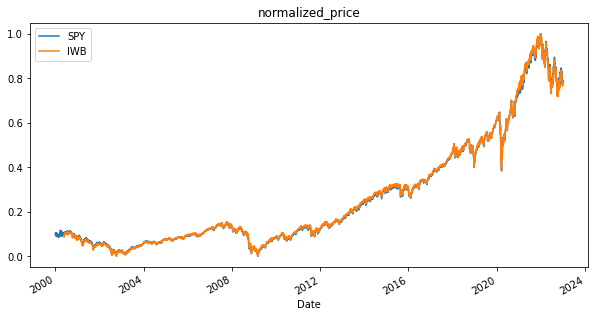

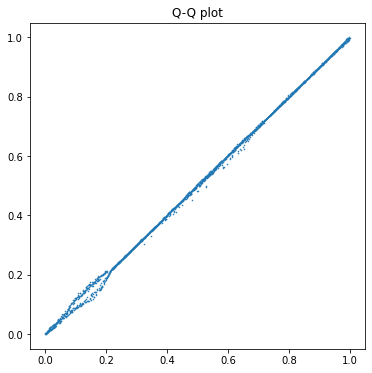

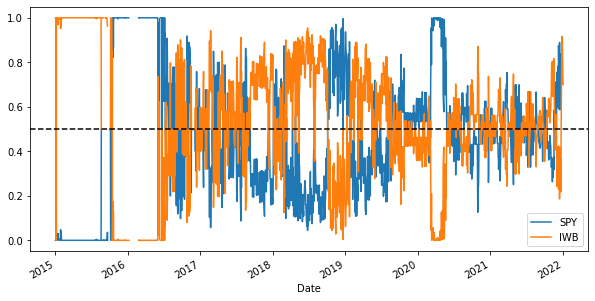

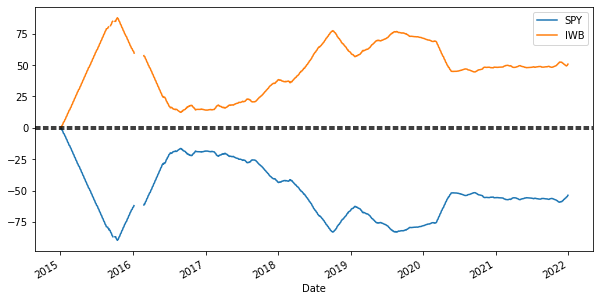

In [24]:
df_p = get_MI_df('SPY','IWB', training_start, training_end, method='normalized_price')

In [25]:
df_p

,MI_u_v,MI_v_u
Date,,
2015-01-02,0.000183,9.998081e-01
2015-01-05,0.000425,9.995557e-01
2015-01-06,1.000000,1.254718e-07
2015-01-07,0.000893,9.990691e-01
2015-01-08,0.008288,9.914630e-01
...,...,...
2021-12-27,0.818204,9.141097e-01
2021-12-28,0.779241,7.792413e-01
2021-12-29,0.914110,8.182039e-01


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Kendall Tau: 0.9477311111954307
Copula:  frank   theta:  47.78605061950472  AIC score:  -inf


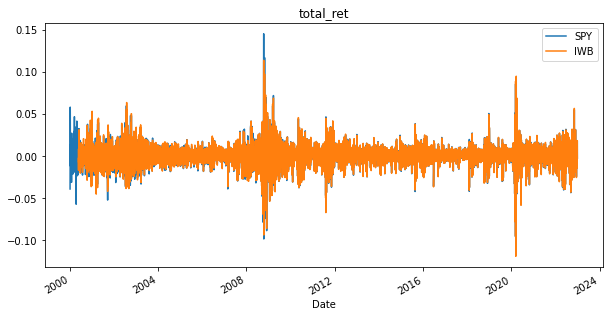

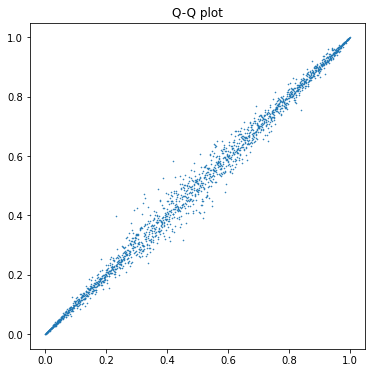

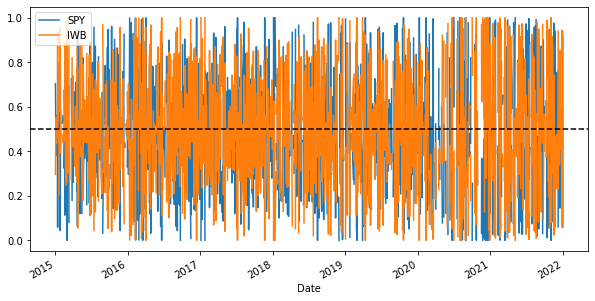

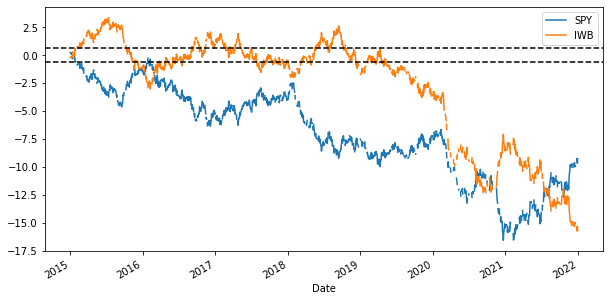

In [26]:
df_p = get_MI_df('SPY','IWB', training_start, training_end, method='total_ret')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Kendall Tau: 0.9477336865884526
Copula:  frank   theta:  47.78673513229211  AIC score:  -inf


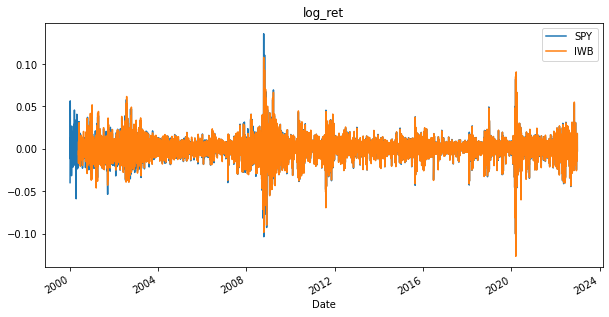

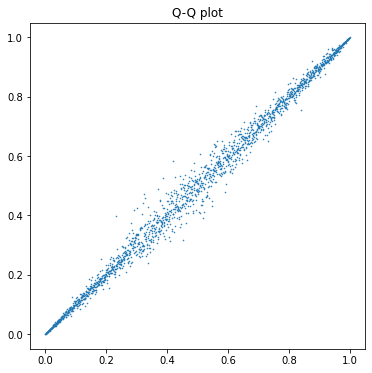

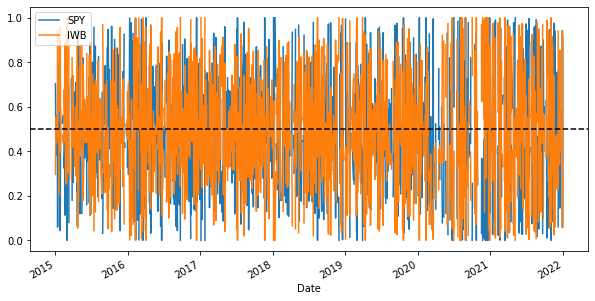

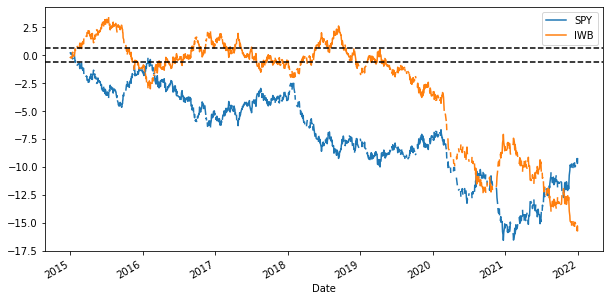

In [27]:
df_p = get_MI_df('SPY','IWB', training_start, training_end, method='log_ret')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Kendall Tau: 0.4289094555925596
Copula:  clayton   theta:  1.502071640978028  AIC score:  -873.8107001948547


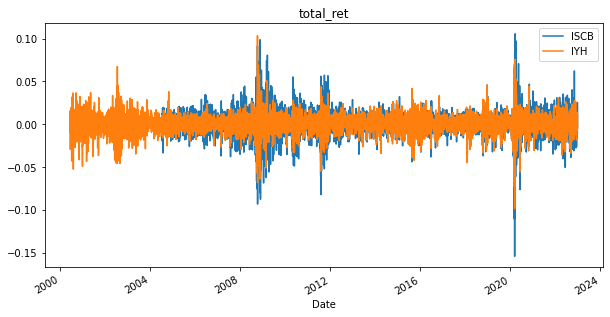

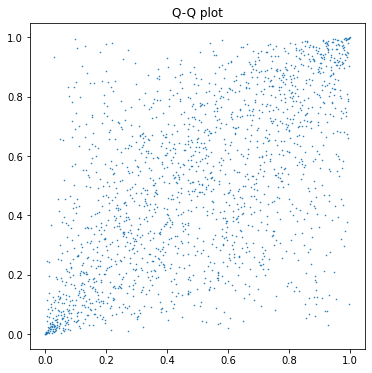

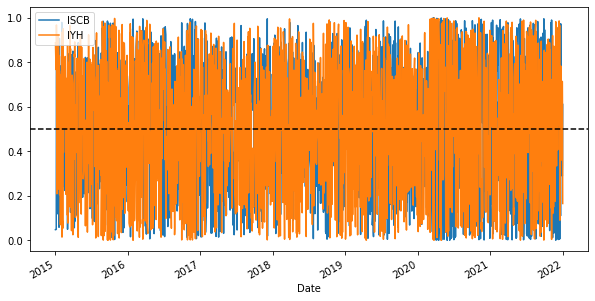

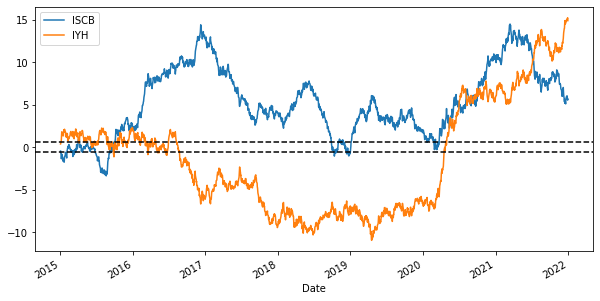

In [28]:
df_p = get_MI_df('ISCB','IYH', training_start, training_end, method='total_ret')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Kendall Tau: 0.4995373873392021
Copula:  gumbel   theta:  1.9981512598580011  AIC score:  -1170.6908854365981


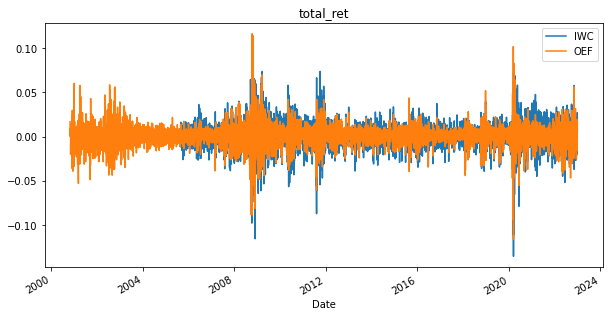

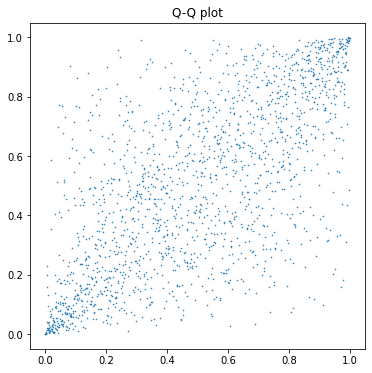

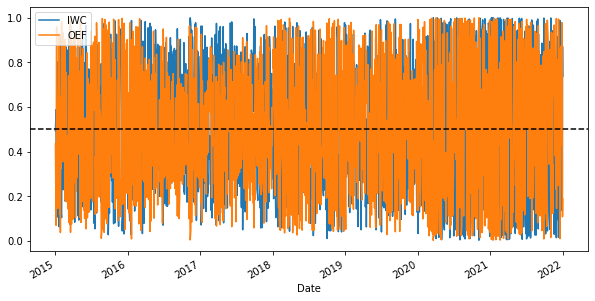

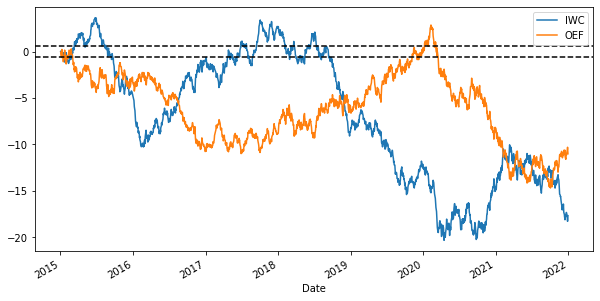

In [29]:
df_p = get_MI_df('IWC','OEF', training_start, training_end, method='total_ret')

In [91]:
df_all = df_with_copula[df_with_copula.Ticker_Pair=='ISCB_IYH'].reset_index(drop=True)

In [92]:
df_all['y_1'] = df_all['Y_Fwd_Total_Ret_Pct_1'].shift(-1)
#df_all['y_5'] = df_all['Y_Fwd_Total_Ret_Pct_1'].shift(-5)
#df_all['y_10'] = df_all['Y_Fwd_Total_Ret_Pct_1'].shift(-10)

In [93]:
#req_cols = ['Div Yield', 'Price to Book','Price to Earnings','Total_Ret_Pct_5','Total_Ret_Pct_21','MI_u_v','MI_v_u','y_1','Y_Fwd_Total_Ret_Pct_1']
#features = ['Div Yield', 'Price to Book','Price to Earnings','Total_Ret_Pct_5','Total_Ret_Pct_21','MI_u_v','MI_v_u','y_1']
req_cols = ['y_1','MI_u_v','MI_v_u','Y_Fwd_Total_Ret_Pct_1']
features = ['y_1','MI_u_v','MI_v_u']
dff = dff.dropna()
dff = df_all[req_cols].reset_index(drop=True)
train_size = 0.8

In [94]:
train = dff.iloc[:int(dff.shape[0] * train_size)]
test = dff.iloc[int(dff.shape[0] * train_size):]

In [95]:
train.corr()

,y_1,MI_u_v,MI_v_u,Y_Fwd_Total_Ret_Pct_1
y_1,1.000000,-0.018580,0.033396,0.003401
MI_u_v,-0.018580,1.000000,-0.633594,-0.030597
MI_v_u,0.033396,-0.633594,1.000000,0.052360
Y_Fwd_Total_Ret_Pct_1,0.003401,-0.030597,0.052360,1.000000


## OLS

In [98]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [115]:
df_all = df_with_copula[df_with_copula.Ticker_Pair=='ISCB_IYH'].reset_index(drop=True)

df_all['y_1'] = df_all['Y_Fwd_Total_Ret_Pct_1'].shift(-1)
df_all['y_5'] = df_all['Y_Fwd_Total_Ret_Pct_1'].shift(-5)
df_all['y_10'] = df_all['Y_Fwd_Total_Ret_Pct_1'].shift(-10)

dff = dff.dropna()
dff = df_all[req_cols].reset_index(drop=True)
train_size = 0.8

train = dff.iloc[:int(dff.shape[0] * train_size)]
test = dff.iloc[int(dff.shape[0] * train_size):]

In [111]:

req_cols = ['y_1','y_5','y_10','MI_u_v','MI_v_u','Y_Fwd_Total_Ret_Pct_1']
features = ['y_1','y_5','y_10','MI_u_v','MI_v_u']
scaler = StandardScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)
train = pd.DataFrame(train, columns=req_cols)
test = pd.DataFrame(test,columns = req_cols)

train_x = train[features]
train_y = train['Y_Fwd_Total_Ret_Pct_1']

test_x = test[features]
test_y = test['Y_Fwd_Total_Ret_Pct_1']

In [112]:
train_x = train[features]
train_y = train['Y_Fwd_Total_Ret_Pct_1']
result = sm.OLS(train_y, train_x).fit()
result.summary()

OLS Regression Results 
 
 Dep. Variable: Y_Fwd_Total_Ret_Pct_1 R-squared (uncentered): 0.003 
 
 
 Model: OLS Adj. R-squared (uncentered): 0.002 
 
 
 Method: Least Squares F-statistic: 2.052 
 
 
 Date: Tue, 14 Feb 2023 Prob (F-statistic): 0.0684 
 
 
 Time: 23:47:42 Log-Likelihood: -4878.9 
 
 
 No. Observations: 3442 AIC: 9768. 
 
 
 Df Residuals: 3437 BIC: 9798. 
 
 
 Df Model: 5 
 
 
 Covariance Type: nonrobust 
 
 
 
 
 coef std err t P>|t| [0.025 0.975] 
 
 
 y_1 0.0021 0.017 0.121 0.904 -0.031 0.035 
 
 
 y_5 0.0057 0.017 0.332 0.740 -0.028 0.039 
 
 
 y_10 0.0137 0.017 0.806 0.420 -0.020 0.047 
 
 
 MI_u_v 0.0043 0.022 0.196 0.845 -0.039 0.047 
 
 
 MI_v_u 0.0549 0.022 2.491 0.013 0.012 0.098 
 
 
 
 
 Omnibus: 372.597 Durbin-Watson: 2.050 
 
 
 Prob(Omnibus): 0.000 Jarque-Bera (JB): 3304.002 
 
 
 Skew: 0.001 Prob(JB): 0.00 
 
 
 Kurtosis: 7.800 Cond. No. 2.12 
 
 Notes: [1] R² is computed without centering (uncentered) since the model does not contain a constant. [2] Standard Errors assume that the covariance matrix of the errors is correctly specified.

In [127]:
req_cols = ['Div Yield', 'Price to Book','Price to Earnings','Total_Ret_Pct_5','Total_Ret_Pct_21','MI_u_v','MI_v_u','Y_Fwd_Total_Ret_Pct_1']
features = ['Div Yield', 'Price to Book','Price to Earnings','Total_Ret_Pct_5','Total_Ret_Pct_21','MI_u_v','MI_v_u']

dff = dff.dropna()
dff = df_all[req_cols].reset_index(drop=True)

train = dff.iloc[:int(dff.shape[0] * train_size)]
test = dff.iloc[int(dff.shape[0] * train_size):]

scaler = StandardScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)
train = pd.DataFrame(train, columns=req_cols)
test = pd.DataFrame(test,columns = req_cols)
train.dropna(inplace=True)
test.dropna(inplace=True)



train_x = train[features]
train_y = train['Y_Fwd_Total_Ret_Pct_1']

test_x = test[features]
test_y = test['Y_Fwd_Total_Ret_Pct_1']


In [128]:
result = sm.OLS(train_y, train_x).fit()
result.summary()

OLS Regression Results 
 
 Dep. Variable: Y_Fwd_Total_Ret_Pct_1 R-squared (uncentered): 0.005 
 
 
 Model: OLS Adj. R-squared (uncentered): 0.003 
 
 
 Method: Least Squares F-statistic: 2.227 
 
 
 Date: Tue, 14 Feb 2023 Prob (F-statistic): 0.0294 
 
 
 Time: 23:52:59 Log-Likelihood: -4852.3 
 
 
 No. Observations: 3421 AIC: 9719. 
 
 
 Df Residuals: 3414 BIC: 9761. 
 
 
 Df Model: 7 
 
 
 Covariance Type: nonrobust 
 
 
 
 
 coef std err t P>|t| [0.025 0.975] 
 
 
 Div Yield -0.0190 0.021 -0.909 0.363 -0.060 0.022 
 
 
 Price to Book 0.0096 0.021 0.457 0.648 -0.032 0.051 
 
 
 Price to Earnings -0.0057 0.018 -0.325 0.745 -0.040 0.029 
 
 
 Total_Ret_Pct_5 0.0396 0.021 1.910 0.056 -0.001 0.080 
 
 
 Total_Ret_Pct_21 -0.0067 0.020 -0.339 0.734 -0.045 0.032 
 
 
 MI_u_v -0.0118 0.023 -0.503 0.615 -0.058 0.034 
 
 
 MI_v_u 0.0544 0.022 2.455 0.014 0.011 0.098 
 
 
 
 
 Omnibus: 362.795 Durbin-Watson: 2.044 
 
 
 Prob(Omnibus): 0.000 Jarque-Bera (JB): 3116.601 
 
 
 Skew: -0.003 Prob(JB): 0.00 
 
 
 Kurtosis: 7.676 Cond. No. 2.53 
 
 Notes: [1] R² is computed without centering (uncentered) since the model does not contain a constant. [2] Standard Errors assume that the covariance matrix of the errors is correctly specified.

## XGBOOST

In [51]:
import xgboost as xg
from sklearn.preprocessing import StandardScaler

In [80]:

# scaler = StandardScaler()
# train = scaler.fit_transform(train)
# test = scaler.transform(test)
# train = pd.DataFrame(train, columns=req_cols)
# test = pd.DataFrame(test,columns = req_cols)

train_x = train[features]
train_y = train['Y_Fwd_Total_Ret_Pct_1']

test_x = test[features]
test_y = test['Y_Fwd_Total_Ret_Pct_1']

In [82]:
xgb_r = xg.XGBRegressor(objective ='reg:linear',n_estimators = 10, seed = 25)

xgb_r.fit(train_x, train_y)
pred = xgb_r.predict(test_x)
pred = pd.DataFrame(pred)
# pred = scaler.inverse_transform(pred)

[23:29:05] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


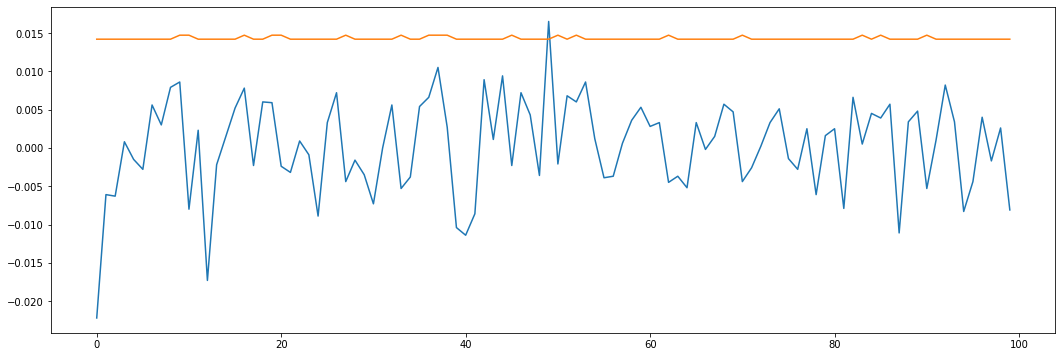

In [86]:
plt.figure(figsize=(18,6))
plt.plot(test_y.reset_index(drop=True)[:100])
plt.plot(pred[:100])

## LSTM Model

In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler 

In [22]:
additional_metrics = ['MeanAbsolutePercentageError']
batch_size = 128
number_of_epochs = 5
validation_split = 0.20
verbosity_mode = 1

In [45]:
# scaler = MinMaxScaler(feature_range=(0,1))
# train = scaler.fit_transform(train)
# test = scaler.transform(test)
# train = pd.DataFrame(train, columns=req_cols)
# test = pd.DataFrame(test,columns = req_cols)
train_x = train[features]
train_y = train['Y_Fwd_Total_Ret_Pct_1']

test_x = test[features]
test_y = test['Y_Fwd_Total_Ret_Pct_1']

In [46]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(train_y.shape[1],1)))
model.add(layers.LSTM(100, return_sequences=False, input_shape=(train_y.shape[1],1)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(25))
# model.add(layers.Dropout(.1))
model.add(layers.Dense(1))
model.summary()

IndexError: IndexError: tuple index out of range

In [ ]:
plt.plto

In [39]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_x, train_y, batch_size= 1, epochs=3)

Epoch 1/3
3442/3442 [==============================] - 23s 6ms/step - loss: nan
Epoch 2/3
3442/3442 [==============================] - 22s 6ms/step - loss: nan
Epoch 3/3
3442/3442 [==============================] - 21s 6ms/step - loss: nan


In [40]:
preds = model.predict(test_x)
preds = scaler.inverse_transform(preds)

ValueError: ValueError: non-broadcastable output operand with shape (861,1) doesn't match the broadcast shape (861,8)

In [ ]:
data = rui.filter(['Close'])
train = data[:training_data_len]
test = data[training_data_len:]
test['Predictions'] = preds
plt.figure(figsize=(16,8))
plt.title('Russel 1000 predictions by LSTM')
plt.xlabel('Date')
plt.ylabel('Close Index Value')
# plt.plot(train)
plt.plot(test[['Close', 'Predictions']])
plt.legend(['Test', 'Predictions'], loc='upper right')
plt.show()